# Dog Breed Classification using CNN

Import required libraries

In [29]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import patches

from sklearn.datasets import load_files
from skimage import data
from skimage.feature import Cascade
from skimage import io

from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

from glob import glob
from tqdm import tqdm
from PIL import ImageFile

Function definitions

In [28]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = io.imread(img_path)
    detected = detector.detect_multi_scale(img=img,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(60, 60),
                                       max_size=(123, 123))
    return len(detected) > 0

# detect number of faces in a given image set
def face_detector_performance(files):
    cnt = 0
    for i in files:
        if face_detector(i) == True:
            cnt += 1
    return (cnt/len(files))*100

# Takes a string-valued file path to a color image as input and returns a 4D tensor
# suitable for supplying to a Keras CNN
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    return np.expand_dims(x,axis=0)

# Takes a numpy array of string-valued image paths as input and returns a 4D tensor
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### returns breed of detected dog or closest dog breed to detected human
def breed_detector(img_path):
    img = io.imread(img_path)
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = my_model.predict(bottleneck_feature)
    predicted_name = dog_names[np.argmax(predicted_vector)]
    
    plt.imshow(img)
    plt.show()
    if face_detector(img_path):
        print("Face Detected. Closest Dog Breed: " + predicted_name)
    elif dog_detector(img_path):
        print("Dog detected. Predicted breed: " + predicted_name)      
    else:
        print("Error, neither human nor dog detected")

ResNet50_Imagenet_model = ResNet50(weights='imagenet')
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_Imagenet_model.predict(img))

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

def extract_Xception(tensor):
    return Xception(weights='imagenet', include_top=False).predict(xception_preprocess_input(tensor))

Specify paths of images and other relevant files

In [3]:
training_folder_path = 'dog-project-master/dogImages/train'
validation_folder_path = 'dog-project-master/dogImages/valid'
test_folder_path = 'dog-project-master/dogImages/test'
human_images_folder_path = 'dog-project-master/lfw/lfw'
vgg_16_features_path = 'dog-project-master/bottleneck_features/DogVGG16Data.npz'
vgg_19_features_path = 'dog-project-master/bottleneck_features/DogVGG19Data.npz'
resnet_features_path = 'dog-project-master/bottleneck_features/DogResnet50Data.npz'
inception_features_path = 'dog-project-master/bottleneck_features/DogInceptionV3Data.npz'
xception_features_path = 'dog-project-master/bottleneck_features/DogXceptionData.npz'
new_test_images_path = 'dog-project-master/test_images'

## Step 0: Import Datasets

### Import Dog Datasets

In [4]:
# load train, test, and validation datasets
train_files, train_targets = load_dataset(training_folder_path)
valid_files, valid_targets = load_dataset(validation_folder_path)
test_files, test_targets = load_dataset(test_folder_path)

# load list of dog names
dog_names = [item[39:-1] for item in sorted(glob(training_folder_path + "/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In [5]:
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob(human_images_folder_path + "/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


## Step 1: Detect Humans

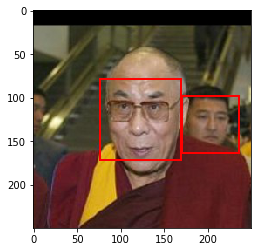

In [6]:
# Load the trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()


# Initialize the detector cascade.
detector = Cascade(trained_file)

img = io.imread(human_files[2])

detected = detector.detect_multi_scale(img=img,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(60, 60),
                                       max_size=(123, 123))

plt.imshow(img)
img_desc = plt.gca()
plt.set_cmap('gray')

for patch in detected:

    img_desc.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill=False,
            color='r',
            linewidth=2
        )
    )

plt.show()

### Performance of the skimage face detector on a set of test images

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

print("Humans:{:.2f}%".format(face_detector_performance(human_files_short)))
print("Dogs:{:.2f}%".format(face_detector_performance(dog_files_short)))


Humans:80.00%
Dogs:4.00%


In the first 100 human files 80% have human face detected.
In the first 100 dog images 4% have human face detected.

## Step 2: Create a CNN to Classify Dog Breeds (from Scratch)

In [8]:
#Rescale the images by dividing every pixel in every image by 255.
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:04<00:00, 187.81it/s]


### Model Architecture

In [9]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
model.add(Conv2D(filters=64,kernel_size=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
model.add(Conv2D(filters=128,kernel_size=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       3

### Compile the model

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [11]:
epochs = 20

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)


Epoch 1/20
334/334 [==============================] - ETA: 0s - loss: 4.8677 - accuracy: 0.0145
Epoch 00001: val_loss improved from inf to 4.69303, saving model to weights.best.from_scratch.hdf5
334/334 [==============================] - 92s 276ms/step - loss: 4.8677 - accuracy: 0.0145 - val_loss: 4.6930 - val_accuracy: 0.0251
Epoch 2/20
334/334 [==============================] - ETA: 0s - loss: 4.6077 - accuracy: 0.0328
Epoch 00002: val_loss improved from 4.69303 to 4.48346, saving model to weights.best.from_scratch.hdf5
334/334 [==============================] - 89s 267ms/step - loss: 4.6077 - accuracy: 0.0328 - val_loss: 4.4835 - val_accuracy: 0.0467
Epoch 3/20
334/334 [==============================] - ETA: 0s - loss: 4.3315 - accuracy: 0.0540
Epoch 00003: val_loss improved from 4.48346 to 4.24603, saving model to weights.best.from_scratch.hdf5
334/334 [==============================] - 89s 266ms/step - loss: 4.3315 - accuracy: 0.0540 - val_loss: 4.2460 - val_accuracy: 0.0766
Epoch

### Load the Model with the Best Validation Loss

In [12]:
model.load_weights('weights.best.from_scratch.hdf5')

### Test the Model

In [13]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
#test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
#print('Test accuracy: %.4f%%' % test_accuracy)
count = 0
for i, j in zip(np.array(dog_breed_predictions),np.argmax(test_targets,axis=1)):
    if(i==j):
        count += 1
test_accuracy = (count/len(dog_breed_predictions)) * 100
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 8.8517%


## Step 3: Create a CNN to Classify Dog Breeds (using Transfer Learning)
### Compare VGG16, VGG19, ResNET-50, Inception and Xception models

In [14]:
### Obtain bottleneck features from another VGG 16.
bottleneck_features = np.load(vgg_16_features_path)
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

### Obtain bottleneck features from VGG 19.
bottleneck_features = np.load(vgg_19_features_path)
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(133, activation='softmax'))

### Obtain bottleneck features from Resnet-50
bottleneck_features = np.load(resnet_features_path)
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

### Obtain bottleneck features from InceptionV3
bottleneck_features = np.load(inception_features_path)
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))

### Obtain bottleneck features from Xception
bottleneck_features = np.load(xception_features_path)
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))

In [15]:
### Summarize the models.
VGG16_model.summary()
VGG19_model.summary()
Resnet50_model.summary()
InceptionV3_model.summary()
Xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
__

In [16]:
### Compile the models.
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
### Train the models.

checkpointerVGG16 = ModelCheckpoint(filepath='weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)
VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointerVGG16], verbose=1)

checkpointerVGG19 = ModelCheckpoint(filepath='weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)
VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointerVGG19], verbose=1)

checkpointerResnet50 = ModelCheckpoint(filepath='weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)
Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointerResnet50], verbose=1)

checkpointerInceptionV3 = ModelCheckpoint(filepath='weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)
InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointerInceptionV3], verbose=1)

checkpointerXception = ModelCheckpoint(filepath='weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)
Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointerXception], verbose=1)

Epoch 1/20
323/334 [============================>.] - ETA: 0s - loss: 7.9835 - accuracy: 0.2291
Epoch 00001: val_loss improved from inf to 3.41567, saving model to weights.best.VGG16.hdf5
334/334 [==============================] - 7s 21ms/step - loss: 7.8186 - accuracy: 0.2374 - val_loss: 3.4157 - val_accuracy: 0.4743
Epoch 2/20
317/334 [===========================>..] - ETA: 0s - loss: 2.2067 - accuracy: 0.5943
Epoch 00002: val_loss improved from 3.41567 to 2.44577, saving model to weights.best.VGG16.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 2.1836 - accuracy: 0.5993 - val_loss: 2.4458 - val_accuracy: 0.5509
Epoch 3/20
322/334 [===========================>..] - ETA: 0s - loss: 1.2340 - accuracy: 0.7394
Epoch 00003: val_loss improved from 2.44577 to 2.16982, saving model to weights.best.VGG16.hdf5
334/334 [==============================] - 7s 22ms/step - loss: 1.2346 - accuracy: 0.7404 - val_loss: 2.1698 - val_accuracy: 0.6204
Epoch 4/20
320/334 [=============

330/334 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9417
Epoch 00008: val_loss did not improve from 1.69583
334/334 [==============================] - 2s 6ms/step - loss: 0.2126 - accuracy: 0.9410 - val_loss: 1.9082 - val_accuracy: 0.7042
Epoch 9/20
325/334 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9525
Epoch 00009: val_loss did not improve from 1.69583
334/334 [==============================] - 1s 4ms/step - loss: 0.1598 - accuracy: 0.9509 - val_loss: 1.7961 - val_accuracy: 0.7257
Epoch 10/20
319/334 [===========================>..] - ETA: 0s - loss: 0.1129 - accuracy: 0.9680
Epoch 00010: val_loss did not improve from 1.69583
334/334 [==============================] - 1s 3ms/step - loss: 0.1181 - accuracy: 0.9669 - val_loss: 1.9015 - val_accuracy: 0.7054
Epoch 11/20
318/334 [===========================>..] - ETA: 0s - loss: 0.0978 - accuracy: 0.9684
Epoch 00011: val_loss did not improve from 1.69583
334/334 [===================

Epoch 17/20
322/334 [===========================>..] - ETA: 0s - loss: 0.0075 - accuracy: 0.9972
Epoch 00017: val_loss did not improve from 0.63662
334/334 [==============================] - 2s 6ms/step - loss: 0.0074 - accuracy: 0.9973 - val_loss: 0.8862 - val_accuracy: 0.8323
Epoch 18/20
325/334 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9985
Epoch 00018: val_loss did not improve from 0.63662
334/334 [==============================] - 1s 4ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.9173 - val_accuracy: 0.8228
Epoch 19/20
328/334 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9980
Epoch 00019: val_loss did not improve from 0.63662
334/334 [==============================] - 1s 4ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.8949 - val_accuracy: 0.8395
Epoch 20/20
333/334 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9979
Epoch 00020: val_loss did not improve from 0.63662
334/334 [======

Epoch 6/20
328/334 [============================>.] - ETA: 0s - loss: 0.2170 - accuracy: 0.9335
Epoch 00006: val_loss did not improve from 0.46859
334/334 [==============================] - 12s 36ms/step - loss: 0.2181 - accuracy: 0.9332 - val_loss: 0.5065 - val_accuracy: 0.8599
Epoch 7/20
332/334 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9414
Epoch 00007: val_loss did not improve from 0.46859
334/334 [==============================] - 12s 36ms/step - loss: 0.1936 - accuracy: 0.9412 - val_loss: 0.5300 - val_accuracy: 0.8515
Epoch 8/20
328/334 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9488
Epoch 00008: val_loss did not improve from 0.46859
334/334 [==============================] - 69s 208ms/step - loss: 0.1736 - accuracy: 0.9490 - val_loss: 0.5436 - val_accuracy: 0.8587
Epoch 9/20
329/334 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9520
Epoch 00009: val_loss did not improve from 0.46859
334/334 [===

In [18]:
### Load the model weights with the best validation loss.
VGG16_model.load_weights('weights.best.VGG16.hdf5')

VGG19_model.load_weights('weights.best.VGG19.hdf5')

Resnet50_model.load_weights('weights.best.Resnet50.hdf5')

InceptionV3_model.load_weights('weights.best.InceptionV3.hdf5')

Xception_model.load_weights('weights.best.Xception.hdf5')

In [19]:
### Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy for VGG16: %.4f%%' % test_accuracy)

# get index of predicted dog breed for each image in test set
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]
# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy for VGG19: %.4f%%' % test_accuracy)

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy ResNet: %.4f%%' % test_accuracy)

# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]
# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy for Inception V3: %.4f%%' % test_accuracy)

# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy for Xception: %.4f%%' % test_accuracy)

Test accuracy for VGG16: 72.9665%
Test accuracy for VGG19: 72.2488%
Test accuracy ResNet: 80.1435%
Test accuracy for Inception V3: 82.6555%
Test accuracy for Xception: 84.3301%


## Step 4: Create a CNN using Transfer Learning

Create a model using Xception pre-trained model

In [20]:
my_model = Sequential()
my_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
my_model.add(Dense(1032, activation='relu'))
my_model.add(Dropout(0.4))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dropout(0.4))
my_model.add(Dense(133, activation='softmax'))

my_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1032)              2114568   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1032)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               264448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               34181     
Total params: 2,413,197
Trainable params: 2,413,197
Non-trainable params: 0
____________________________________________

In [26]:
my_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointerMyModel = ModelCheckpoint(filepath='weights.best.MyModel.hdf5', 
                               verbose=1, save_best_only=True)

my_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=64, callbacks=[checkpointerMyModel], verbose=1)

Epoch 1/20
103/105 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9583
Epoch 00001: val_loss improved from inf to 1.31016, saving model to weights.best.MyModel.hdf5
105/105 [==============================] - 11s 108ms/step - loss: 0.1691 - accuracy: 0.9582 - val_loss: 1.3102 - val_accuracy: 0.8359
Epoch 2/20
104/105 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9621
Epoch 00002: val_loss did not improve from 1.31016
105/105 [==============================] - 3s 30ms/step - loss: 0.1334 - accuracy: 0.9621 - val_loss: 1.3170 - val_accuracy: 0.8371
Epoch 3/20
105/105 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9626
Epoch 00003: val_loss improved from 1.31016 to 1.25548, saving model to weights.best.MyModel.hdf5
105/105 [==============================] - 20s 187ms/step - loss: 0.1469 - accuracy: 0.9626 - val_loss: 1.2555 - val_accuracy: 0.8443
Epoch 4/20
104/105 [============================>.] - ETA: 0s - loss:

In [27]:
# get index of predicted dog breed for each image in test set
my_model_predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
my_model_accuracy = 100*np.sum(np.array(my_model_predictions)==np.argmax(test_targets, axis=1))/len(my_model_predictions)
print('Test accuracy for my model: %.4f%%' % my_model_accuracy)

Test accuracy for my model: 85.4067%


## Step 5: Testing model on new images

There are 7 total test images.


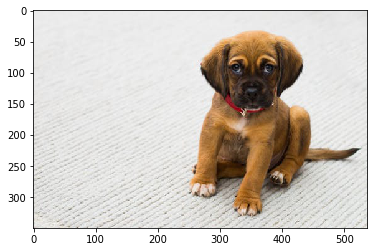

Dog detected. Predicted breed: Leonberger


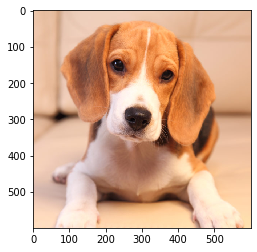

Dog detected. Predicted breed: Beagle


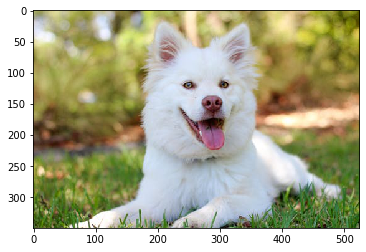

Dog detected. Predicted breed: American_eskimo_dog


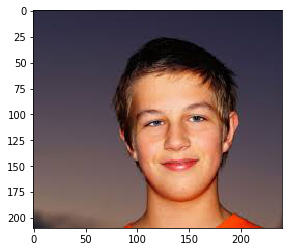

Face Detected. Closest Dog Breed: Nova_scotia_duck_tolling_retriever


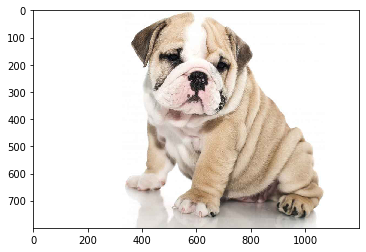

Dog detected. Predicted breed: Bulldog


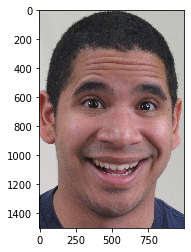

Error, neither human nor dog detected


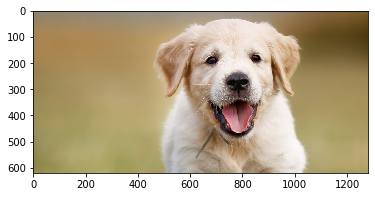

Dog detected. Predicted breed: Golden_retriever


In [30]:
model_test_files = np.array(glob(new_test_images_path + "/*"))
random.shuffle(model_test_files)

print('There are %d total test images.' % len(model_test_files))

for i in model_test_files:
    breed_detector(i)